# 모듈 import

In [1]:
import pandas as pd

# selenium
# !pip install selenium
from selenium import webdriver
from bs4 import BeautifulSoup
import time
# pd.set_option('display.max_columns', None) # 데이터프레임 컬럼 display

from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore') # 경고 무시

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rc("font", family = "Malgun Gothic")

<br>
<br>

# 가설 목록
1. `홈경기`일 때 승리에 영향을 미치는가?
2. 전 경기에서 `3:0`으로 졌다면, 다음 경기에서 영향을 받을까?
3. `용병` 출전 횟수가 경기에 영향을 미칠까?
4. 어떤 `feature`가 경기 결과에 영향을 미칠까?

<br>
<br>

# 데이터 전처리

* `크롤링` 한 부분 : 경기장, 관중수, 세트 스코어 + 기존 크롤링 코드
* `Feature Engineering` : '최종_범실총합', '최종_공격종합_시도', '최종_수비_정확', '최종_득점_득점', '최종_서브_시도',  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'최종_공격종합_공격차단', '최종_세트_시도', '최종_세트_성공', '최종_수비_성공률'  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`수비` : 블로킹 + 리시브 + 디그
* `New Feature` : 'new_hypo'
* `del Feature` : 'score' : target과 일치  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; '득점', '서브 시도', '리시브 시도' : 높은 상관관계

In [2]:
df = pd.read_csv(f'volleyball_fin.csv')
df_raw = pd.read_csv('volleyball_raw.csv')
df_WS = pd.read_csv('./volleyball_fin.csv')

pd.set_option('display.max_columns', None)
col = [
      '팀명','경기장','관중수','경기날짜','결과','1팀score','2팀score','이름','득점_득점','공격종합_시도','공격종합_성공','공격종합_공격차단','공격종합_범실','공격종합_성공률','공격종합_점유율','오픈_시도','오픈_성공','오픈_공격차단','오픈_범실','오픈_성공률','오픈_점유율','시간차_시도','시간차_성공','시간차_공격차단',
      '시간차_범실','시간차_성공률','시간차_점유율','이동_시도','이동_성공','이동_공격차단','이동_범실','이동_성공률','이동_점유율','후위_시도','후위_성공','후위_공격차단','후위_범실','후위_성공률','후위_점유율','속공_시도','속공_성공','속공_공격차단','속공_범실','속공_성공률','속공_점유율','퀵오픈_시도','퀵오픈_성공','퀵오픈_공격차단',
      '퀵오픈_범실','퀵오픈_성공률','퀵오픈_점유율','서브_시도','서브_성공','서브_범실','서브_성공률','서브_점유율','디그_시도','디그_성공','디그_실패','디그_범실','디그_세트당','디그_점유율','세트_시도','세트_성공','세트_범실','세트_세트당','세트_점유율','리시브_시도','리시브_정확','리시브_실패','리시브_세트당','리시브_점유율',
      '블로킹_시도','블로킹_성공','블로킹_유효블락','블로킹_실패','블로킹_범실','블로킹_세트당','블로킹_점유율','블로킹_어시스트','벌칙_벌칙','범실_범실','포지션','득점점유율','스타팅멤버',
    ];
st = df_WS['경기장'][0]
date = df_WS['경기날짜'][0]
cnt = 1
num = [1]
for d in range(1, len(df_WS)):
    if (st == (df_WS['경기장'][d]))&(date == (df_WS['경기날짜'][d])):
        num.append(cnt)
    else:
        cnt += 1
        st = df_WS['경기장'][d]
        date = df_WS['경기날짜'][d]
        num.append(cnt)
df_WS['경기번호'] = num
df_WS = df_WS[['경기번호'] + col]
df_WS.to_csv(f'volleyball_gg.csv', index = False)
df_yw = pd.read_csv('./volleyball_gg.csv')
df_yw = df_WS.drop(['공격종합_범실', '오픈_범실', '시간차_범실',            
                    '이동_범실', '후위_범실', '속공_범실', '퀵오픈_범실', '디그_범실', '블로킹_범실', '블로킹_세트당','오픈_시도', '시간차_시도', '이동_시도', '후위_시도', '속공_시도', '퀵오픈_시도',
                    '오픈_성공', '시간차_성공', '이동_성공', '후위_성공', '속공_성공', '퀵오픈_성공','오픈_공격차단', '시간차_공격차단', '이동_공격차단', '후위_공격차단', '속공_공격차단', '퀵오픈_공격차단','이름','오픈_점유율', '시간차_점유율',            
                    '이동_점유율', '후위_점유율', '속공_점유율', '퀵오픈_점유율', '서브_점유율', '디그_점유율', '세트_점유율', '리시브_점유율','블로킹_점유율', '디그_세트당', '리시브_세트당', '블로킹_세트당', '세트_세트당', '오픈_성공률', '시간차_성공률',
                    '이동_성공률', '후위_성공률', '속공_성공률', '퀵오픈_성공률', '공격종합_성공률', '공격종합_점유율', '서브_성공률', '블로킹_어시스트'
                   ],axis=1)
df_ge = df_yw.groupby(['경기번호', '팀명', '1팀score', '2팀score'],sort=False)[['득점_득점', '공격종합_시도', '공격종합_성공', '공격종합_공격차단',
       '서브_시도', '서브_성공', '서브_범실', '디그_시도', '디그_성공', '디그_실패', '세트_시도', '세트_성공',
       '세트_범실', '리시브_시도', '리시브_정확', '리시브_실패', '블로킹_시도', '블로킹_성공', '블로킹_유효블락',
       '블로킹_실패', '벌칙_벌칙', '범실_범실']].sum()

df_ge.reset_index(inplace=True)

score = []

for s in range(0, len(df_ge),2):
    score.append(df_ge['1팀score'][s])
    score.append(df_ge['2팀score'][s])

data_ge = df_ge.drop(['1팀score', '2팀score'], axis=1)
data_ge['score'] = score
# encoding_cols = ['팀명']
# df_yw2 = pd.get_dummies(data_ge, columns = encoding_cols)
# df_yw2.head()

team_name = data_ge['팀명'].astype('category')
team_name = team_name.cat.codes
data_ge['팀명'] = team_name
df_yw1 = data_ge.groupby(['경기번호']).sum()
import numpy as np
leftteam = []
rightteam = []
for i in range(len(data_ge.index)):
    if i%2 == 0:
        leftteam.append(data_ge.iloc[i,:])
    else:
        rightteam.append(data_ge.iloc[i,:])
leftteam = pd.DataFrame(np.array(leftteam))
leftteam.columns = ['경기번호','팀명','득점_득점', '공격종합_시도', '공격종합_성공', '공격종합_공격차단',
       '서브_시도', '서브_성공', '서브_범실', '디그_시도', '디그_성공', '디그_실패', '세트_시도', '세트_성공',
       '세트_범실', '리시브_시도', '리시브_정확', '리시브_실패', '블로킹_시도', '블로킹_성공', '블로킹_유효블락',
       '블로킹_실패', '벌칙_벌칙', '범실_범실','score']
rightteam = pd.DataFrame(np.array(rightteam))
rightteam.columns = ['2경기번호','2팀명','2득점_득점', '2공격종합_시도', '2공격종합_성공', '2공격종합_공격차단',
       '2서브_시도', '2서브_성공', '2서브_범실', '2디그_시도', '2디그_성공', '2디그_실패', '2세트_시도', '2세트_성공',
       '2세트_범실', '2리시브_시도', '2리시브_정확', '2리시브_실패', '2블로킹_시도', '2블로킹_성공', '2블로킹_유효블락',
       '2블로킹_실패', '2벌칙_벌칙', '2범실_범실','2score']
df_yw2 = pd.concat([leftteam,rightteam], axis=1)
df_yw2
df_yw2[['팀명','2팀명']] = df_yw2[['팀명','2팀명']].astype('category')
result = []

for i in range(0,473):
    #1team 2team 중 score가 0인 팀을 찾음
    dif_score = 0
    if df_yw2.iloc[i][24] == 0:
        zero_team = df_yw2.iloc[i][1]
        for j in range(i+1,473):
            if df_yw2.iloc[j][1] == zero_team:
                dif_score = df_yw2.iloc[j][24] - df_yw2.iloc[j][49] 
                break
            elif df_yw2.iloc[j][26] == zero_team:
                dif_score = df_yw2.iloc[j][49] - df_yw2.iloc[j][24] 
                break
        
    elif df_yw2.iloc[i][49] == 0:
        zero_team = df_yw2.iloc[i][26]
        for j in range(i+1,473):
            if df_yw2.iloc[j][1] == zero_team:
                dif_score = df_yw2.iloc[j][24] - df_yw2.iloc[j][49] 
                break
            elif df_yw2.iloc[j][26] == zero_team:
                dif_score = df_yw2.iloc[j][49] - df_yw2.iloc[j][24] 
                break
    result.append(dif_score)
        
result.append(0)
len(result)
df_yw2['new_hypo']=result
#음수가 많으면 가설 검증 완료 (3:0 (0인 팀의 다음경기 스코어 - 0인팀 상대편의 스코어))
win_lose1 = []
win_lose2 = []
for i in range(0,474):
    if df_yw2.iloc[i][24] - df_yw2.iloc[i][49] < 0:
        win_lose1.append(0)
        win_lose2.append(1)
    else:
        win_lose1.append(1)
        win_lose2.append(0)
df_yw2['팀1승패'] = win_lose1
df_yw2['팀2승패'] = win_lose2
df_yw2['디그_성공률'] = df_yw2['디그_성공'] / df_yw2['디그_시도']
df_yw2['2디그_성공률'] = df_yw2['2디그_성공'] / df_yw2['2디그_시도']
df_yw2['리시브_성공률'] = df_yw2['리시브_정확'] / df_yw2['리시브_시도']
df_yw2['2리시브_성공률'] = df_yw2['2리시브_정확'] / df_yw2['2리시브_시도']
df_yw2['블로킹_성공률'] = df_yw2['블로킹_성공'] / df_yw2['블로킹_시도']
df_yw2['2블로킹_성공률'] = df_yw2['2블로킹_성공'] / df_yw2['2블로킹_시도']
df_yw2['범실총합'] = df_yw2['서브_범실'] + df_yw2['세트_범실'] + df_yw2['범실_범실']
df_yw2['2범실총합'] = df_yw2['2서브_범실'] + df_yw2['2세트_범실'] + df_yw2['2범실_범실']
df_yw2['수비_성공률'] = (df_yw2['디그_성공률'] + df_yw2['리시브_성공률'] + df_yw2["블로킹_성공률"]) / 2
df_yw2['2수비_성공률'] = (df_yw2['2디그_성공률'] + df_yw2['2리시브_성공률'] + df_yw2["2블로킹_성공률"]) / 2
df_yw2['블로킹+리시브_정확'] = df_yw2['블로킹_유효블락'] + df_yw2['리시브_정확']
df_yw2['2블로킹+리시브_정확'] = df_yw2['2블로킹_유효블락'] + df_yw2['2리시브_정확']
df_yw3 = df_yw2.drop(['경기번호', '공격종합_성공','팀2승패',  '2공격종합_성공', '서브_성공',  '2서브_성공', '2경기번호', '디그_성공', '디그_시도', '2디그_성공', '2디그_시도', '디그_실패', '2디그_실패',  '리시브_정확', '리시브_시도', '2리시브_정확', '2리시브_시도', '블로킹_성공', '블로킹_시도', '2블로킹_성공', '2블로킹_시도',
               '서브_범실', '세트_범실', '범실_범실', '2서브_범실', '2세트_범실', '2범실_범실', '디그_성공률', '리시브_성공률', '2디그_성공률', '2리시브_성공률', '블로킹_성공률', '2블로킹_성공률', '벌칙_벌칙', '2벌칙_벌칙', '블로킹_유효블락', '2블로킹_유효블락', '리시브_정확', '2리시브_정확', '블로킹_실패', '2블로킹_실패'], axis=1)
df_yw3['최종_범실총합'] = df_yw3['범실총합'] - df_yw3['2범실총합']
df_yw3['최종_공격종합_시도'] = df_yw3['공격종합_시도'] - df_yw3['2공격종합_시도']
df_yw3['최종_수비_정확'] = df_yw3['블로킹+리시브_정확'] - df_yw3['2블로킹+리시브_정확']
df_yw3['최종_득점_득점'] = df_yw3['득점_득점'] - df_yw3['2득점_득점']
df_yw3['최종_서브_시도'] = df_yw3['서브_시도'] - df_yw3['2서브_시도']
df_yw3['최종_공격종합_공격차단'] = df_yw3['공격종합_공격차단'] - df_yw3['2공격종합_공격차단']
df_yw3['최종_세트_시도'] = df_yw3['세트_시도'] - df_yw3['2세트_시도']
df_yw3['최종_세트_성공'] = df_yw3['세트_성공'] - df_yw3['2세트_성공']
df_yw3['최종_수비_성공률'] = df_yw3['수비_성공률'] - df_yw3['2수비_성공률']
df_final = df_yw3.drop(['득점_득점', '서브_시도', '공격종합_공격차단', '세트_시도','범실총합','2범실총합','수비_성공률','2수비_성공률'
                      ,'블로킹+리시브_정확','2블로킹+리시브_정확','공격종합_시도','2공격종합_시도','세트_성공', '2세트_성공',
                      '2득점_득점', '2서브_시도', '2공격종합_공격차단', '2세트_시도'],axis=1)
df_final

,팀명,리시브_실패,score,2팀명,2리시브_실패,2score,new_hypo,팀1승패,최종_범실총합,최종_공격종합_시도,최종_수비_정확,최종_득점_득점,최종_서브_시도,최종_공격종합_공격차단,최종_세트_시도,최종_세트_성공,최종_수비_성공률
0,1,5,3,6,7,2,0,1,-1,-13,-4,-13,-11,5,-7,-10,-0.094394
1,2,5,2,5,5,3,0,0,-25,5,0,-24,-11,13,0,-12,-0.074813
2,4,9,2,0,7,3,0,0,-4,-18,0,-6,-1,-2,-17,-6,-0.035030
3,1,3,2,5,7,3,0,0,0,9,12,-6,-5,7,11,-3,0.022026
4,6,3,3,2,8,2,0,1,10,2,-11,18,8,-2,4,12,0.027363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,3,1,0,0,2,3,-3,0,7,7,-9,-2,14,1,80,35,-0.199553
470,2,2,3,5,6,2,0,1,-11,-12,3,1,7,-2,-38,-9,0.009850
471,1,3,3,6,4,0,0,1,5,0,16,21,22,-5,6,21,0.088118
472,4,3,3,3,4,0,0,1,6,14,11,33,15,-4,-97,-26,0.213497


## heatmap (column 상관관계)

<AxesSubplot:>

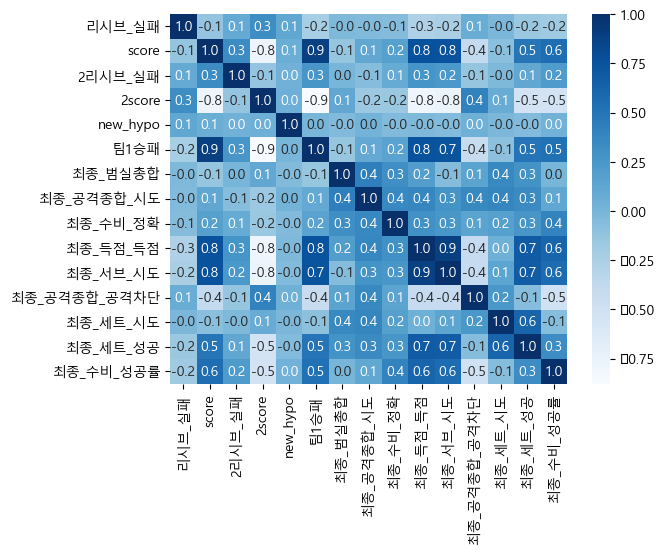

In [3]:
sns.heatmap(df_final.corr(), annot=True, cmap='Blues', fmt=".1f")

### ML 성능을 높히기 위한 전처리
* Outlier 제거

<table>
    <tr>
        <td>
            <center>
            <h2>outlier 제거 전 </h2>
            </center>
           <a href='https://ifh.cc/v-aGQvwO' target='_blank'><img src='https://ifh.cc/g/aGQvwO.png' border='0'></a>
        </td>
        <td>
            <center>
            <h2>outlier 제거 후 </h2>
            </center>
            <a href='https://ifh.cc/v-dVBv2f' target='_blank'><img src='https://ifh.cc/g/dVBv2f.png' border='0'></a>
        </td>
    <tr>
</table>

<table>
    <tr>
        <td>
            <center>
            <h2>outlier 제거 전 </h2>
            </center>
            <a href='https://ifh.cc/v-t5N8rH' target='_blank'><img src='https://ifh.cc/g/t5N8rH.jpg' border='0'></a>
        </td>
        <td>
            <center>
            <h2>outlier 제거 후 </h2>
            </center>
            <a href='https://ifh.cc/v-5fN4K6' target='_blank'><img src='https://ifh.cc/g/5fN4K6.jpg' border='0'></a>
        </td>
    <tr>
</table>

<hr>

# Model별 성능 확인 + k-fold 함수 작성

In [4]:
# !pip install xgboost
# !pip install lightgbm
from ast import operator
from math import gamma
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

import itertools

# data의 모든 columns를 가지고 scaling 후
# 'LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'XGBClassifier', 'SVC', 'KNN', 'GaussianNB'
# 위의 Model들의 학습과 score, MSE 확인하는 함수 작성

def digimon_normal(X, y, f_size):
    SEED = 42
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, stratify=y)
    kfold = KFold(n_splits=f_size, shuffle=True, random_state=42)
    model_name = ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'XGBClassifier', 'SVC', 'KNN', 'GaussianNB']
    models_cnt = len(model_name)

    pipeline_logi = make_pipeline(
    StandardScaler(),
    LogisticRegression()
    )

    pipeline_deci = make_pipeline(
        StandardScaler(),
        DecisionTreeClassifier(max_depth=4)
    )

    pipeline_rfc = make_pipeline(
        StandardScaler(),
        RandomForestClassifier(random_state = SEED, max_depth=4)
    )
    pipeline_xgb = make_pipeline(
        StandardScaler(),
        XGBClassifier(random_state = SEED)
    )

    pipeline_svm = make_pipeline(
        StandardScaler(),
        SVC(gamma='auto')
    )

    pipeline_knn = make_pipeline(
        StandardScaler(),
        KNeighborsClassifier()
    )

    pipeline_gnb = make_pipeline(
        StandardScaler(),
        GaussianNB()
    )

    train_list = [0 for i in range(models_cnt)]
    test_list = [0 for i in range(models_cnt)]
    mse_list = [0 for i in range(models_cnt)]

    accuracy = [0 for i in range(models_cnt)]
    precision = [0 for i in range(models_cnt)]
    recall = [0 for i in range(models_cnt)]
    f1 = [0 for i in range(models_cnt)]

    for train_index, test_index in kfold.split(X):
        x_train_fold, x_valid_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_valid_fold = y.iloc[train_index], y.iloc[test_index]
        
        # Logistic
        tester = pipeline_logi.fit(x_train_fold, y_train_fold)
        train_list[0] += pipeline_logi.score(x_train_fold, y_train_fold)
        test_list[0] +=  pipeline_logi.score(x_valid_fold, y_valid_fold)
        mse_list[0] += mean_squared_error(y_valid_fold, pipeline_logi.predict(x_valid_fold))

        accuracy[0] += accuracy_score(y_test, tester.predict(X_test))
        precision[0] += precision_score(y_test, tester.predict(X_test), average='micro')
        recall[0] += recall_score(y_test, tester.predict(X_test), average='micro')
        f1[0] += f1_score(y_test, tester.predict(X_test), average='micro')
        # DecisionTree Classifier
        tester = pipeline_deci.fit(x_train_fold, y_train_fold)
        train_list[1] += pipeline_deci.score(x_train_fold, y_train_fold)
        test_list[1] +=  pipeline_deci.score(x_valid_fold, y_valid_fold)
        mse_list[1] += mean_squared_error(y_valid_fold, pipeline_deci.predict(x_valid_fold))

        accuracy[1] += accuracy_score(y_test, tester.predict(X_test))
        precision[1] += precision_score(y_test, tester.predict(X_test), average='micro')
        recall[1] += recall_score(y_test, tester.predict(X_test), average='micro')
        f1[1] += f1_score(y_test, tester.predict(X_test), average='micro')
        # Random Forest Classifier
        tester = pipeline_rfc.fit(x_train_fold, y_train_fold)
        train_list[2] += pipeline_rfc.score(x_train_fold, y_train_fold)
        test_list[2] +=  pipeline_rfc.score(x_valid_fold, y_valid_fold)
        mse_list[2] += mean_squared_error(y_valid_fold, pipeline_rfc.predict(x_valid_fold))

        accuracy[2] += accuracy_score(y_test, tester.predict(X_test))
        precision[2] += precision_score(y_test, tester.predict(X_test), average='micro')
        recall[2] += recall_score(y_test, tester.predict(X_test), average='micro')
        f1[2] += f1_score(y_test, tester.predict(X_test), average='micro')
        # XGBClassifier
        tester = pipeline_xgb.fit(X_train, y_train)
        train_list[3] += pipeline_xgb.score(x_train_fold, y_train_fold)
        test_list[3] +=  pipeline_xgb.score(x_valid_fold, y_valid_fold)
        mse_list[3] += mean_squared_error(y_valid_fold, pipeline_xgb.predict(x_valid_fold))

        accuracy[3] += accuracy_score(y_test, tester.predict(X_test))
        precision[3] += precision_score(y_test, tester.predict(X_test), average='micro')
        recall[3] += recall_score(y_test, tester.predict(X_test), average='micro')
        f1[3] += f1_score(y_test, tester.predict(X_test), average='micro')
        # SVM
        tester = pipeline_svm.fit(X_train, y_train)
        train_list[4] += pipeline_svm.score(x_train_fold, y_train_fold)
        test_list[4] +=  pipeline_svm.score(x_valid_fold, y_valid_fold)
        mse_list[4] += mean_squared_error(y_valid_fold, pipeline_svm.predict(x_valid_fold))

        accuracy[4] += accuracy_score(y_test, tester.predict(X_test))
        precision[4] += precision_score(y_test, tester.predict(X_test), average='micro')
        recall[4] += recall_score(y_test, tester.predict(X_test), average='micro')
        f1[4] += f1_score(y_test, tester.predict(X_test), average='micro')
        # KNN
        tester = pipeline_knn.fit(X_train, y_train)
        train_list[5] += pipeline_knn.score(x_train_fold, y_train_fold)
        test_list[5] +=  pipeline_knn.score(x_valid_fold, y_valid_fold)
        mse_list[5] += mean_squared_error(y_valid_fold, pipeline_knn.predict(x_valid_fold))

        accuracy[5] += accuracy_score(y_test, tester.predict(X_test))
        precision[5] += precision_score(y_test, tester.predict(X_test), average='micro')
        recall[5] += recall_score(y_test, tester.predict(X_test), average='micro')
        f1[5] += f1_score(y_test, tester.predict(X_test), average='micro')
        # GaussianNB
        tester = pipeline_gnb.fit(X_train, y_train)
        train_list[6] += pipeline_gnb.score(x_train_fold, y_train_fold)
        test_list[6] +=  pipeline_gnb.score(x_valid_fold, y_valid_fold)
        mse_list[6] += mean_squared_error(y_valid_fold, pipeline_gnb.predict(x_valid_fold))

        accuracy[6] += accuracy_score(y_test, tester.predict(X_test))
        precision[6] += precision_score(y_test, tester.predict(X_test), average='micro')
        recall[6] += recall_score(y_test, tester.predict(X_test), average='micro')
        f1[6] += f1_score(y_test, tester.predict(X_test), average='micro')
    for i, v in enumerate(model_name):
        print(v+' 모델 정확도: {}, 정밀도: {}, 재현율: {},  F1: {}'.format(accuracy[i]/models_cnt, precision[i]/models_cnt, recall[i]/models_cnt, f1[i]/ models_cnt))
    train_test_list = list(map(lambda x : x / f_size, train_list+test_list))
    mse_list = list(map(lambda x : x / f_size, mse_list))
    temp = pd.DataFrame(list([model_name ,train_test_list[::2], train_test_list[1::2], mse_list])).T
    temp.columns = ['모델명', 'train score', 'test score', 'mse']
    return temp

In [5]:
X2 = df_final.drop(['new_hypo', '팀1승패', 'score', '2score'], 1)
y = df_final['팀1승패']
digimon_normal(X2, y, 3)

LogisticRegression 모델 정확도: 0.38415366146458585, 정밀도: 0.38415366146458585, 재현율: 0.38415366146458585,  F1: 0.38415366146458585
DecisionTreeClassifier 모델 정확도: 0.3949579831932773, 정밀도: 0.3949579831932773, 재현율: 0.3949579831932773,  F1: 0.39495798319327735
RandomForestClassifier 모델 정확도: 0.39615846338535415, 정밀도: 0.39615846338535415, 재현율: 0.39615846338535415,  F1: 0.3961584633853542
XGBClassifier 모델 정확도: 0.3817527010804322, 정밀도: 0.3817527010804322, 재현율: 0.3817527010804322,  F1: 0.3817527010804322
SVC 모델 정확도: 0.39255702280912363, 정밀도: 0.39255702280912363, 재현율: 0.39255702280912363,  F1: 0.39255702280912363
KNN 모델 정확도: 0.3853541416566627, 정밀도: 0.3853541416566627, 재현율: 0.3853541416566627,  F1: 0.3853541416566627
GaussianNB 모델 정확도: 0.37815126050420167, 정밀도: 0.37815126050420167, 재현율: 0.37815126050420167,  F1: 0.37815126050420167


,모델명,train score,test score,mse
0,LogisticRegression,0.915612,0.945148,0.101266
1,DecisionTreeClassifier,0.940928,0.972574,0.135021
2,RandomForestClassifier,0.938819,0.915612,0.124473
3,XGBClassifier,0.898734,0.898734,0.027426
4,SVC,0.864979,0.875527,0.061181
5,KNN,0.972574,0.938819,0.084388
6,GaussianNB,0.915612,0.898734,0.101266


</br>
</br>
</br>

### Decision Tree의 Importance feature 확인

<a href='https://ifh.cc/v-nH0zP3' target='_blank'><img src='https://ifh.cc/g/nH0zP3.png' border='0'></a>
<a href='https://ifh.cc/v-bBxbWQ' target='_blank'><img src='https://ifh.cc/g/bBxbWQ.png' border='0'></a>
<h3> [결론] </h3>
<a href='https://ifh.cc/v-rW7X2o' target='_blank'><img src='https://ifh.cc/g/rW7X2o.png' border='0'></a>


### ∴ 세트 성공이 승리와 연관성이 높다.
해당 시즌 세터 1위가 포함된 팀은 3,1,2,3,2 위로 상위권 팀에 속하게 되는 것을 알 수 있었습니다.

In [6]:
X1 = df_final.drop(['new_hypo', '팀1승패', 'score', '2score', '최종_득점_득점', '최종_서브_시도'], 1)
y = df_final['팀1승패']
digimon_normal(X1, y, 3)

LogisticRegression 모델 정확도: 0.3865546218487395, 정밀도: 0.3865546218487395, 재현율: 0.3865546218487395,  F1: 0.3865546218487395
DecisionTreeClassifier 모델 정확도: 0.38175270108043213, 정밀도: 0.38175270108043213, 재현율: 0.38175270108043213,  F1: 0.3817527010804322
RandomForestClassifier 모델 정확도: 0.40816326530612246, 정밀도: 0.40816326530612246, 재현율: 0.40816326530612246,  F1: 0.40816326530612246
XGBClassifier 모델 정확도: 0.3817527010804322, 정밀도: 0.3817527010804322, 재현율: 0.3817527010804322,  F1: 0.3817527010804322
SVC 모델 정확도: 0.3817527010804322, 정밀도: 0.3817527010804322, 재현율: 0.3817527010804322,  F1: 0.3817527010804322
KNN 모델 정확도: 0.3709483793517407, 정밀도: 0.3709483793517407, 재현율: 0.3709483793517407,  F1: 0.3709483793517407
GaussianNB 모델 정확도: 0.3601440576230492, 정밀도: 0.3601440576230492, 재현율: 0.3601440576230492,  F1: 0.3601440576230492


,모델명,train score,test score,mse
0,LogisticRegression,0.914557,0.916667,0.107595
1,DecisionTreeClassifier,0.946203,0.972574,0.225738
2,RandomForestClassifier,0.940928,0.888186,0.160338
3,XGBClassifier,0.85654,0.892405,0.027426
4,SVC,0.774262,0.839662,0.059072
5,KNN,0.972574,0.940928,0.111814
6,GaussianNB,0.888186,0.85654,0.14346


## 시각화 함수 작성

In [7]:
def make_plt(X, y, f_size ):
    
    score_plot = digimon_normal(X, y, 4)
    score_plot.index = score_plot['모델명']
    score_plot.drop('모델명',1,inplace=True)
#     display(score_plot)
    fig, axes = plt.subplots(2,1)

    score_plot['mse'].plot(kind='barh',figsize=(15,6), xlabel='Model_name',title='MSE_Value', color ={'green', 'blue', 'red', 'yellow', 'orange', 'black', 'gray'}, ax=axes[0])

    score_plot.drop('mse',1).plot(kind='barh',figsize=(15,6), xlabel='Model_name',title='Train,Test_accuracy', xlim=(0,1.1), ax=axes[1])
    fig.tight_layout()
    plt.show()


LogisticRegression 모델 정확도: 0.5150060024009604, 정밀도: 0.5150060024009604, 재현율: 0.5150060024009604,  F1: 0.5150060024009604
DecisionTreeClassifier 모델 정확도: 0.5150060024009604, 정밀도: 0.5150060024009604, 재현율: 0.5150060024009604,  F1: 0.5150060024009604
RandomForestClassifier 모델 정확도: 0.5474189675870348, 정밀도: 0.5474189675870348, 재현율: 0.5474189675870348,  F1: 0.5474189675870348
XGBClassifier 모델 정확도: 0.5090036014405762, 정밀도: 0.5090036014405762, 재현율: 0.5090036014405762,  F1: 0.5090036014405763
SVC 모델 정확도: 0.5090036014405762, 정밀도: 0.5090036014405762, 재현율: 0.5090036014405762,  F1: 0.5090036014405763
KNN 모델 정확도: 0.4945978391356543, 정밀도: 0.4945978391356543, 재현율: 0.4945978391356543,  F1: 0.4945978391356543
GaussianNB 모델 정확도: 0.4801920768307323, 정밀도: 0.4801920768307323, 재현율: 0.4801920768307323,  F1: 0.4801920768307323


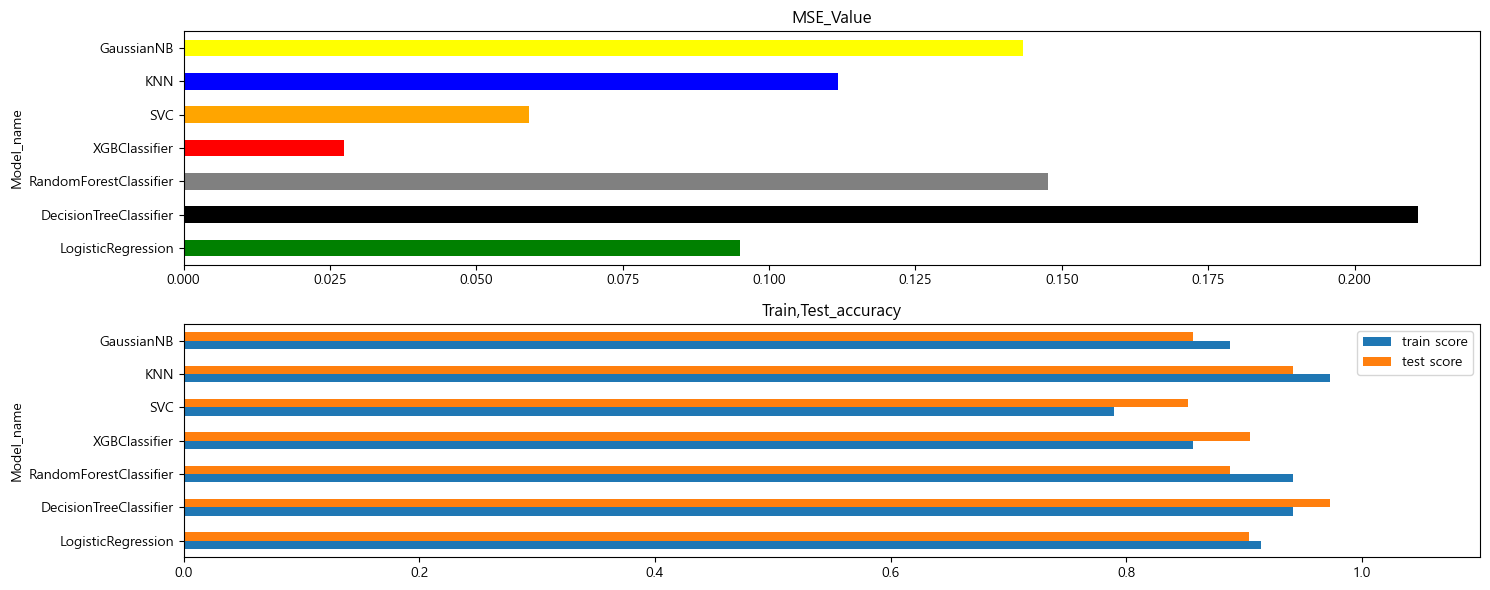

In [8]:
# 모든 column의 ML 결과
make_plt(X1, y, 3)

### feature Engineering Polynomial 진행

In [9]:
from sklearn.preprocessing import PolynomialFeatures

def my_poly(X):
    poly = PolynomialFeatures(2)
    X_poly = poly.fit_transform(X)
    X_poly = pd.DataFrame(X_poly)
    X_poly.columns = poly.get_feature_names(X.columns)
    return X_poly

LogisticRegression 모델 정확도: 0.5318127250900361, 정밀도: 0.5318127250900361, 재현율: 0.5318127250900361,  F1: 0.5318127250900361
DecisionTreeClassifier 모델 정확도: 0.5114045618247298, 정밀도: 0.5114045618247298, 재현율: 0.5114045618247298,  F1: 0.5114045618247299
RandomForestClassifier 모델 정확도: 0.5438175270108043, 정밀도: 0.5438175270108043, 재현율: 0.5438175270108043,  F1: 0.5438175270108043
XGBClassifier 모델 정확도: 0.4897959183673469, 정밀도: 0.4897959183673469, 재현율: 0.4897959183673469,  F1: 0.4897959183673469
SVC 모델 정확도: 0.5282112845138055, 정밀도: 0.5282112845138055, 재현율: 0.5282112845138055,  F1: 0.5282112845138055
KNN 모델 정확도: 0.49939975990396157, 정밀도: 0.49939975990396157, 재현율: 0.49939975990396157,  F1: 0.49939975990396157
GaussianNB 모델 정확도: 0.43217286914765907, 정밀도: 0.43217286914765907, 재현율: 0.43217286914765907,  F1: 0.43217286914765907


,모델명,train score,test score,mse
0,LogisticRegression,0.951478,0.924745,0.141362
1,DecisionTreeClassifier,0.951482,0.964134,0.2025
2,RandomForestClassifier,0.949365,0.883963,0.149836
3,XGBClassifier,0.837557,0.858638,0.035875
4,SVC,0.7975,0.850164,0.050652
5,KNN,0.964125,0.949348,0.116063
6,GaussianNB,0.883937,0.837594,0.162406


LogisticRegression 모델 정확도: 0.5318127250900361, 정밀도: 0.5318127250900361, 재현율: 0.5318127250900361,  F1: 0.5318127250900361
DecisionTreeClassifier 모델 정확도: 0.5126050420168067, 정밀도: 0.5126050420168067, 재현율: 0.5126050420168067,  F1: 0.5126050420168067
RandomForestClassifier 모델 정확도: 0.5438175270108043, 정밀도: 0.5438175270108043, 재현율: 0.5438175270108043,  F1: 0.5438175270108043
XGBClassifier 모델 정확도: 0.4897959183673469, 정밀도: 0.4897959183673469, 재현율: 0.4897959183673469,  F1: 0.4897959183673469
SVC 모델 정확도: 0.5282112845138055, 정밀도: 0.5282112845138055, 재현율: 0.5282112845138055,  F1: 0.5282112845138055
KNN 모델 정확도: 0.49939975990396157, 정밀도: 0.49939975990396157, 재현율: 0.49939975990396157,  F1: 0.49939975990396157
GaussianNB 모델 정확도: 0.43217286914765907, 정밀도: 0.43217286914765907, 재현율: 0.43217286914765907,  F1: 0.43217286914765907


<AxesSubplot:title={'center':'Train,Test_accuracy'}, xlabel='Model_name'>

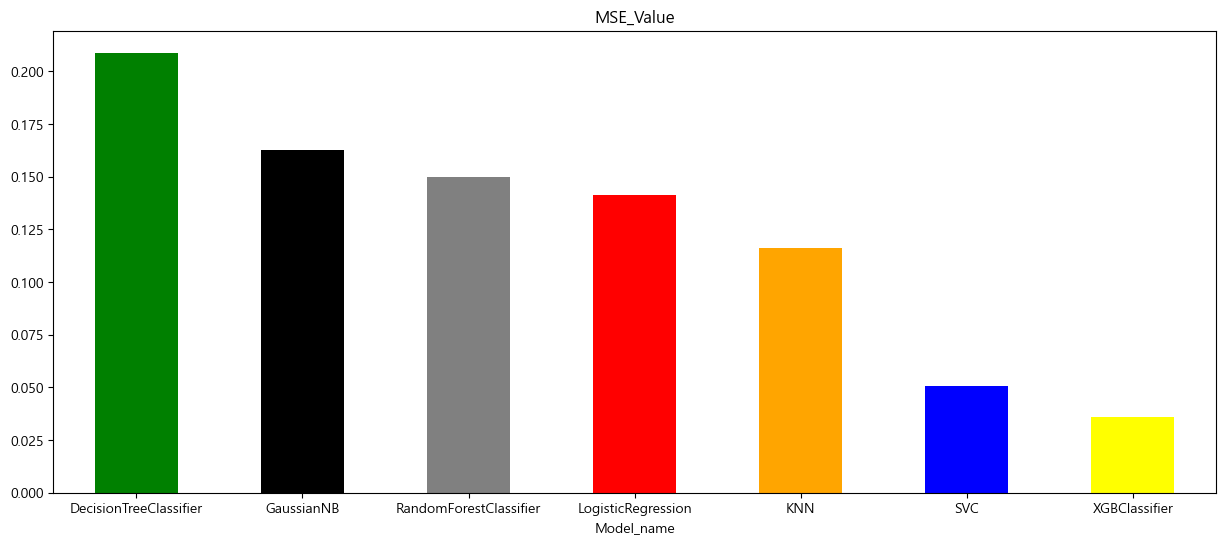

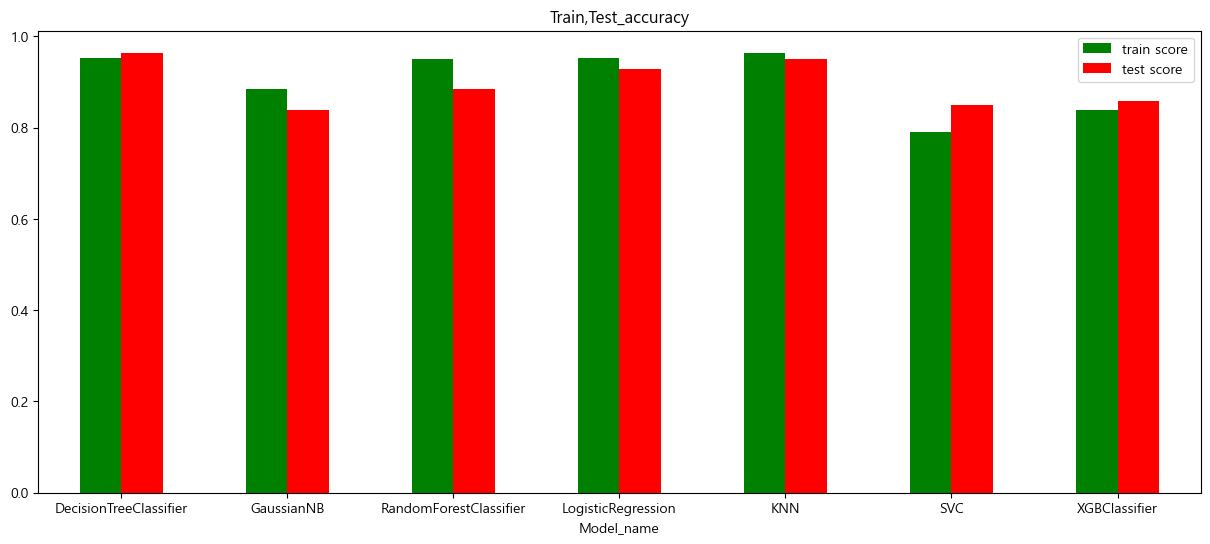

In [10]:
display(digimon_normal(my_poly(X1), y, 4))
poly_plot = digimon_normal(my_poly(X1), y, 4)
poly_plot.index = poly_plot['모델명']
poly_plot.drop('모델명',1,inplace=True)

poly_plot2 = poly_plot.sort_values('mse', ascending = False)
poly_plot2['mse'].plot(kind='bar',rot = 0, figsize=(15,6), xlabel='Model_name',title='MSE_Value', color ={'green', 'blue', 'red', 'yellow', 'orange', 'black', 'gray'})
poly_plot2.drop('mse',1).plot(kind='bar',rot = 0, figsize=(15,6), xlabel='Model_name',title='Train,Test_accuracy', xlim=(0,1.1), color = {'green','red'})

### 이전 경기가 3:0이였을 경우 다음 경기에 지장이 있을까?

LogisticRegression 모델 정확도: 0.5330132052821128, 정밀도: 0.5330132052821128, 재현율: 0.5330132052821128,  F1: 0.5330132052821128
DecisionTreeClassifier 모델 정확도: 0.5282112845138055, 정밀도: 0.5282112845138055, 재현율: 0.5282112845138055,  F1: 0.5282112845138055
RandomForestClassifier 모델 정확도: 0.5318127250900361, 정밀도: 0.5318127250900361, 재현율: 0.5318127250900361,  F1: 0.5318127250900361
XGBClassifier 모델 정확도: 0.5090036014405762, 정밀도: 0.5090036014405762, 재현율: 0.5090036014405762,  F1: 0.5090036014405763
SVC 모델 정확도: 0.5234093637454982, 정밀도: 0.5234093637454982, 재현율: 0.5234093637454982,  F1: 0.5234093637454982
KNN 모델 정확도: 0.5138055222088835, 정밀도: 0.5138055222088835, 재현율: 0.5138055222088835,  F1: 0.5138055222088835
GaussianNB 모델 정확도: 0.4945978391356543, 정밀도: 0.4945978391356543, 재현율: 0.4945978391356543,  F1: 0.4945978391356543


,모델명,train score,test score,mse
0,LogisticRegression,0.961317,0.95289,0.128685
1,DecisionTreeClassifier,0.946558,0.972575,0.149854
2,RandomForestClassifier,0.940926,0.919837,0.116098
3,XGBClassifier,0.898732,0.871315,0.027418
4,SVC,0.850146,0.883902,0.059091
5,KNN,0.972582,0.940909,0.080117
6,GaussianNB,0.919883,0.898715,0.101285


LogisticRegression 모델 정확도: 0.5330132052821128, 정밀도: 0.5330132052821128, 재현율: 0.5330132052821128,  F1: 0.5330132052821128
DecisionTreeClassifier 모델 정확도: 0.5306122448979592, 정밀도: 0.5306122448979592, 재현율: 0.5306122448979592,  F1: 0.5306122448979592
RandomForestClassifier 모델 정확도: 0.5318127250900361, 정밀도: 0.5318127250900361, 재현율: 0.5318127250900361,  F1: 0.5318127250900361
XGBClassifier 모델 정확도: 0.5090036014405762, 정밀도: 0.5090036014405762, 재현율: 0.5090036014405762,  F1: 0.5090036014405763
SVC 모델 정확도: 0.5234093637454982, 정밀도: 0.5234093637454982, 재현율: 0.5234093637454982,  F1: 0.5234093637454982
KNN 모델 정확도: 0.5138055222088835, 정밀도: 0.5138055222088835, 재현율: 0.5138055222088835,  F1: 0.5138055222088835
GaussianNB 모델 정확도: 0.4945978391356543, 정밀도: 0.4945978391356543, 재현율: 0.4945978391356543,  F1: 0.4945978391356543


<AxesSubplot:title={'center':'Train,Test_accuracy'}, xlabel='Model_name'>

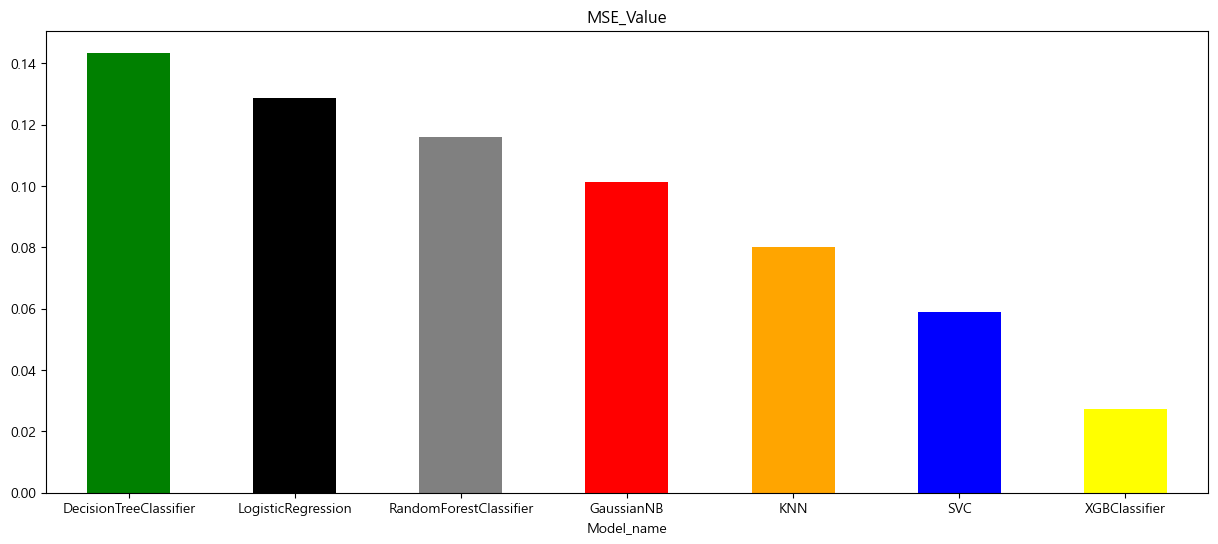

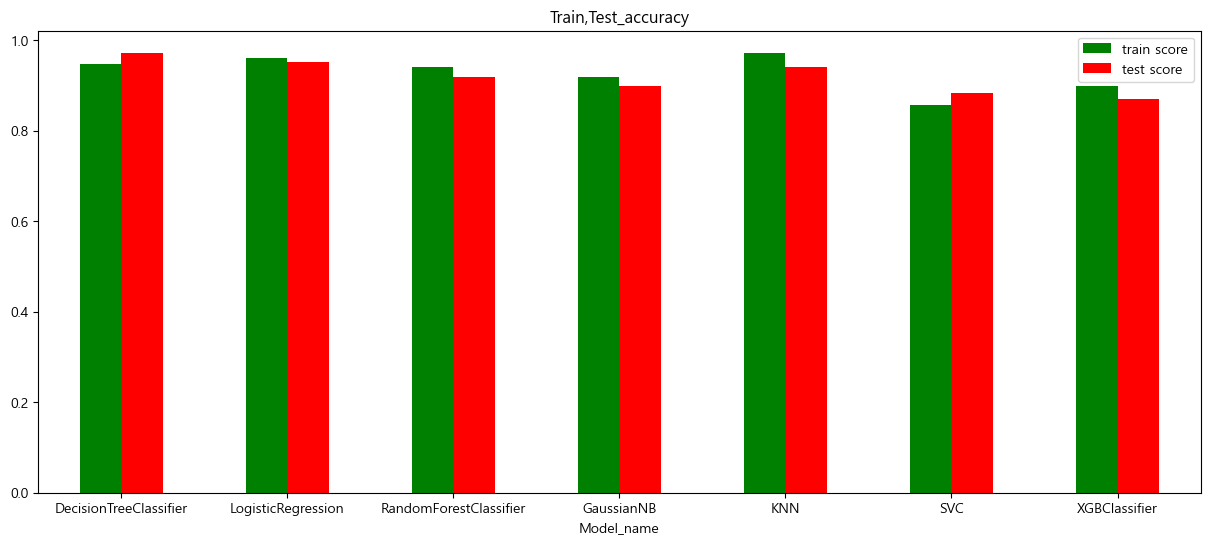

In [11]:
display(digimon_normal(my_poly(X2), y, 4))
poly_plot = digimon_normal(my_poly(X2), y, 4)
poly_plot.index = poly_plot['모델명']
poly_plot.drop('모델명',1,inplace=True)

poly_plot2 = poly_plot.sort_values('mse', ascending = False)
poly_plot2['mse'].plot(kind='bar',rot = 0, figsize=(15,6), xlabel='Model_name',title='MSE_Value', color ={'green', 'blue', 'red', 'yellow', 'orange', 'black', 'gray'})
poly_plot2.drop('mse',1).plot(kind='bar',rot = 0, figsize=(15,6), xlabel='Model_name',title='Train,Test_accuracy', xlim=(0,1.1), color = {'green','red'})

In [12]:
# 성능확인
display(digimon_normal(X1, y, 3), digimon_normal(X2, y, 3))

LogisticRegression 모델 정확도: 0.3865546218487395, 정밀도: 0.3865546218487395, 재현율: 0.3865546218487395,  F1: 0.3865546218487395
DecisionTreeClassifier 모델 정확도: 0.382953181272509, 정밀도: 0.382953181272509, 재현율: 0.382953181272509,  F1: 0.38295318127250905
RandomForestClassifier 모델 정확도: 0.40816326530612246, 정밀도: 0.40816326530612246, 재현율: 0.40816326530612246,  F1: 0.40816326530612246
XGBClassifier 모델 정확도: 0.3817527010804322, 정밀도: 0.3817527010804322, 재현율: 0.3817527010804322,  F1: 0.3817527010804322
SVC 모델 정확도: 0.3817527010804322, 정밀도: 0.3817527010804322, 재현율: 0.3817527010804322,  F1: 0.3817527010804322
KNN 모델 정확도: 0.3709483793517407, 정밀도: 0.3709483793517407, 재현율: 0.3709483793517407,  F1: 0.3709483793517407
GaussianNB 모델 정확도: 0.3601440576230492, 정밀도: 0.3601440576230492, 재현율: 0.3601440576230492,  F1: 0.3601440576230492
LogisticRegression 모델 정확도: 0.38415366146458585, 정밀도: 0.38415366146458585, 재현율: 0.38415366146458585,  F1: 0.38415366146458585
DecisionTreeClassifier 모델 정확도: 0.3949579831932773, 정밀도: 0.394

,모델명,train score,test score,mse
0,LogisticRegression,0.914557,0.916667,0.107595
1,DecisionTreeClassifier,0.946203,0.972574,0.225738
2,RandomForestClassifier,0.940928,0.888186,0.160338
3,XGBClassifier,0.85654,0.892405,0.027426
4,SVC,0.774262,0.839662,0.059072
5,KNN,0.972574,0.940928,0.111814
6,GaussianNB,0.888186,0.85654,0.14346


,모델명,train score,test score,mse
0,LogisticRegression,0.915612,0.945148,0.101266
1,DecisionTreeClassifier,0.940928,0.972574,0.14135
2,RandomForestClassifier,0.938819,0.915612,0.124473
3,XGBClassifier,0.898734,0.898734,0.027426
4,SVC,0.85865,0.875527,0.061181
5,KNN,0.972574,0.938819,0.084388
6,GaussianNB,0.915612,0.898734,0.101266


### ∴ 3:0 으로 질 경우 선수들의 사기 저하로 인해, 다음 경기 승률에 지장이 가서 패배를 할 가능성이 높을 것 같다는 가설이 검증되었습니다.

#### 외국인 선수일 경우 더 뛰어난 실력을 가지고 있을까?

In [13]:
fori = pd.read_csv('./외국인.csv')
f_names=fori['선수명']
f_list = []

for i in f_names:
    for j in i.split():
        if '[' not in j and ']' not in j:
           f_list.append(j) 

a = pd.DataFrame(f_list)
a.columns=['외국인이름']
df_fori = df_raw.copy()

df_fori['외국인'] = df_fori['이름'].apply(lambda x: 1 if x in f_list else 0)
X3 = df_fori.drop(['결과'],axis=1).select_dtypes(include='number')
y3 = df_fori['결과']

digimon_normal(X3 , y3, 3)

LogisticRegression 모델 정확도: 0.31729870129870136, 정밀도: 0.31729870129870136, 재현율: 0.31729870129870136,  F1: 0.31729870129870136
DecisionTreeClassifier 모델 정확도: 0.2512207792207792, 정밀도: 0.2512207792207792, 재현율: 0.2512207792207792,  F1: 0.2512207792207792
RandomForestClassifier 모델 정확도: 0.27324675324675324, 정밀도: 0.27324675324675324, 재현율: 0.27324675324675324,  F1: 0.27324675324675324
XGBClassifier 모델 정확도: 0.3282077922077922, 정밀도: 0.3282077922077922, 재현율: 0.3282077922077922,  F1: 0.3282077922077922
SVC 모델 정확도: 0.2820779220779221, 정밀도: 0.2820779220779221, 재현율: 0.2820779220779221,  F1: 0.2820779220779221
KNN 모델 정확도: 0.24187012987012987, 정밀도: 0.24187012987012987, 재현율: 0.24187012987012987,  F1: 0.24187012987012987
GaussianNB 모델 정확도: 0.24685714285714283, 정밀도: 0.24685714285714283, 재현율: 0.24685714285714283,  F1: 0.24685714285714283


,모델명,train score,test score,mse
0,LogisticRegression,0.734973,0.59448,0.272802
1,DecisionTreeClassifier,0.649313,0.897154,0.422206
2,RandomForestClassifier,0.723652,0.694644,0.382195
3,XGBClassifier,0.57834,0.727198,0.102846
4,SVC,0.577794,0.617805,0.276348
5,KNN,0.897154,0.723652,0.305358
6,GaussianNB,0.694642,0.57834,0.42166


---

# AutoML

<p>python 3.8로 실행</p>
<a href='https://ifh.cc/v-mgQAMd' target='_blank'><img src='https://ifh.cc/g/mgQAMd.png' border='0'></a>
<a href='https://ifh.cc/v-pVDAys' target='_blank'><img src='https://ifh.cc/g/pVDAys.png' border='0'></a>
<a href='https://ifh.cc/v-ZMB6x6' target='_blank'><img src='https://ifh.cc/g/ZMB6x6.png' border='0'></a>
<a href='https://ifh.cc/v-mxK5rf' target='_blank'><img src='https://ifh.cc/g/mxK5rf.png' border='0'></a>
<a href='https://ifh.cc/v-HWYrOf' target='_blank'><img src='https://ifh.cc/g/HWYrOf.png' border='0'></a>

---

# 4조 후기  
  
  
### Best Practice  
1. 저번 프로젝트의 `Lesson Learned를 회고`하며 전처리에 다같이 집중  
2. 데이터를 추출한 뒤 원본과 비교하여 확인하고 잘못된 `결과 확인`  
3. 단계 진행마다 `회의`를 하면서 서로의 진행 상황과 어려운 부분을 확인하며 문제를 해결    
4. 데이터 전처리, 크롤링, 가설 검증, 시각화 `역할 분배`하여 체계적으로 진행   
  
### Lesson Learned  
1. 팀명, 경기 번호를 기준으로 groupby 후 데이터를 넣는 과정에서 정렬이 된 후 값이 들어가서 데이터 값이 꼬였다.  
2. 가설 검증을 위한 데이터 추출 방식을 고민하는데 오랜 시간을 쏟았다.
3. 크롤링 코드를 정확하게 이해하지 못한 상태로 진행하여 오랜 시간을 쏟았다.  